# Idealized synthetic data

*Under development*

In [1]:
import sys; sys.path.append("../../")

import numpy as np
import pandas as pd
import xarray as xr

from melodies_monet import driver

In [2]:
an = driver.analysis()
an.control = "control_idealized.yaml"
an

analysis(
    control='control_idealized.yaml',
    control_dict=None,
    models={},
    obs={},
    paired={},
    start_time=None,
    end_time=None,
    download_maps=True,
    output_dir=None,
    debug=False,
)

In [3]:
an.read_control()
an

analysis(
    control='control_idealized.yaml',
    control_dict=...,
    models={},
    obs={},
    paired={},
    start_time=Timestamp('2019-09-09 00:00:00'),
    end_time=Timestamp('2019-09-10 00:00:00'),
    download_maps=True,
    output_dir='./output/idealized',
    debug=True,
)

````{admonition} Note: This is the complete file that was loaded.
:class: dropdown

```{literalinclude} control_idealized.yaml
:caption:
:linenos:
```
````

## Generate data

### Model

In [4]:
np.random.seed(42)

control = an.control_dict

nlat = 100
nlon = 200

lon = np.linspace(-161, -60, nlon)
lat = np.linspace(18, 72, nlat)

time = pd.date_range(control['analysis']['start_time'], control['analysis']['end_time'], freq="3H")
ntime = time.size

lat_da = xr.DataArray(lat, dims="lat", attrs={'longname': 'latitude', 'units': 'degN'}, name="lat")
lon_da = xr.DataArray(lon, dims="lon", attrs={'longname': 'longitude', 'units': 'degE'}, name="lon")
time_da = xr.DataArray(time, dims="time", name="time")

# Generate dataset
field_names = control['model']['test_model']['variables'].keys()
ds_dict = dict()
for field_name in field_names:
    units = control['model']['test_model']['variables'][field_name]['units']
    data = np.random.rand(ntime, nlat, nlon)
    da = xr.DataArray(
        data,
        # coords={"lat": lat_da, "lon": lon_da, "time": time_da},
        coords=[time_da, lat_da, lon_da],
        dims=['time', 'lat', 'lon'],
        attrs={'units': units},
    )
    ds_dict[field_name] = da
ds = xr.Dataset(ds_dict).expand_dims("z", axis=1)
ds["z"] = [1]
ds

<xarray.Dataset>
Dimensions:  (time: 9, lat: 100, lon: 200, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-09 2019-09-09T03:00:00 ... 2019-09-10
  * lat      (lat) float64 18.0 18.55 19.09 19.64 ... 70.36 70.91 71.45 72.0
  * lon      (lon) float64 -161.0 -160.5 -160.0 -159.5 ... -61.02 -60.51 -60.0
  * z        (z) int32 1
Data variables:
    A        (time, z, lat, lon) float64 0.3745 0.9507 0.732 ... 0.388 0.481
    B        (time, z, lat, lon) float64 0.2141 0.7517 0.2915 ... 0.9236 0.3339

In [5]:
ds.to_netcdf(control['model']['test_model']['files'])

### Obs

In [6]:
# Generate positions
n = 200
lats = np.random.uniform(lat[0], lat[-1], n)[np.newaxis, :]
lons = np.random.uniform(lon[0], lon[-1], n)[np.newaxis, :]
siteid = np.arange(n)[np.newaxis, :].astype(str)

# Generate dataset
field_names = control['model']['test_model']['variables'].keys()
ds_dict = dict()
for field_name0 in field_names:
    field_name = control['model']['test_model']['mapping']['test_obs'][field_name0]
    units = control['model']['test_model']['variables'][field_name0]['units']
    values = np.random.rand(ntime, n)[:, np.newaxis]
    da = xr.DataArray(
        values,
        coords={
            "x": ("x", np.arange(n)),  # !!!
            "time": ("time", time),
            "latitude": (("y", "x"), lats, lat_da.attrs),
            "longitude": (("y", "x"), lons, lon_da.attrs),
            "siteid": (("y", "x"), siteid),
        },
        dims=("time", "y", "x"),
        attrs={'units': units},
    )
    ds_dict[field_name] = da
ds = xr.Dataset(ds_dict)
ds

<xarray.Dataset>
Dimensions:    (x: 200, time: 9, y: 1)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * time       (time) datetime64[ns] 2019-09-09 ... 2019-09-10
    latitude   (y, x) float64 39.65 23.36 53.61 61.53 ... 28.68 57.61 18.14
    longitude  (y, x) float64 -141.9 -111.9 -112.4 ... -89.96 -115.4 -92.18
    siteid     (y, x) <U11 '0' '1' '2' '3' '4' ... '195' '196' '197' '198' '199'
Dimensions without coordinates: y
Data variables:
    A_obs      (time, y, x) float64 0.1128 0.006304 0.4593 ... 0.047 0.01061
    B_obs      (time, y, x) float64 0.3813 0.5989 0.3524 ... 0.889 0.4594 0.4881

In [7]:
ds.to_netcdf(control['obs']['test_obs']['filename'])

## Load data

In [8]:
an.open_models()

test_model
{'files': 'test_model.nc', 'mod_type': 'random', 'variables': {'A': {'units': 'Units of A', 'unit_scale': 1, 'unit_scale_method': '*'}, 'B': {'units': 'Units of B', 'unit_scale': 1, 'unit_scale_method': '*'}}, 'mapping': {'test_obs': {'A': 'A_obs', 'B': 'B_obs'}}, 'projection': 'None'}
test_model.nc


In [9]:
an.models['test_model'].obj

<xarray.Dataset>
Dimensions:  (time: 9, lat: 100, lon: 200, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-09 2019-09-09T03:00:00 ... 2019-09-10
  * lat      (lat) float64 18.0 18.55 19.09 19.64 ... 70.36 70.91 71.45 72.0
  * lon      (lon) float64 -161.0 -160.5 -160.0 -159.5 ... -61.02 -60.51 -60.0
  * z        (z) int32 1
Data variables:
    A        (time, z, lat, lon) float64 0.3745 0.9507 0.732 ... 0.388 0.481
    B        (time, z, lat, lon) float64 0.2141 0.7517 0.2915 ... 0.9236 0.3339

In [10]:
an.open_obs()

In [11]:
an.obs['test_obs'].obj

<xarray.Dataset>
Dimensions:    (x: 200, time: 9, y: 1)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * time       (time) datetime64[ns] 2019-09-09 ... 2019-09-10
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    siteid     (y, x) object ...
Dimensions without coordinates: y
Data variables:
    A_obs      (time, y, x) float64 ...
    B_obs      (time, y, x) float64 ...

In [12]:
%%time

an.pair_data()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
CPU times: total: 109 ms
Wall time: 517 ms


In [13]:
an.paired

{'test_obs_test_model': pair(
     type='pt_sfc',
     radius_of_influence=1000000.0,
     obs='test_obs',
     model='test_model',
     model_vars=['A', 'B'],
     obs_vars=['A_obs', 'B_obs'],
     filename='test_obs_test_model.nc',
 )}

In [14]:
an.paired['test_obs_test_model'].obj

<xarray.Dataset>
Dimensions:    (x: 200, time: 9)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * time       (time) datetime64[ns] 2019-09-09 ... 2019-09-10
Data variables:
    A_obs      (time, x) float64 0.1128 0.006304 0.42 ... 0.1128 0.301 0.5824
    B_obs      (time, x) float64 0.3813 0.5989 0.7093 ... 0.3496 0.1458 0.3421
    A          (time, x) float64 0.3465 0.6346 0.1918 ... 0.4145 0.8486 0.1268
    B          (time, x) float64 0.2077 0.3632 0.734 ... 0.6379 0.7941 0.1875
    latitude   (x) float64 39.65 23.36 43.0 71.79 ... 61.17 66.63 42.07 24.11
    longitude  (x) float64 -141.9 -111.9 -74.41 -123.3 ... -76.49 -63.85 -87.57
    siteid     (x) object '0' '1' '10' '100' '101' ... '95' '96' '97' '98' '99'

In [15]:
an.paired['test_obs_test_model'].obj.dims

Frozen({'x': 200, 'time': 9})

## Plot

CPU times: total: 14.9 s
Wall time: 15 s


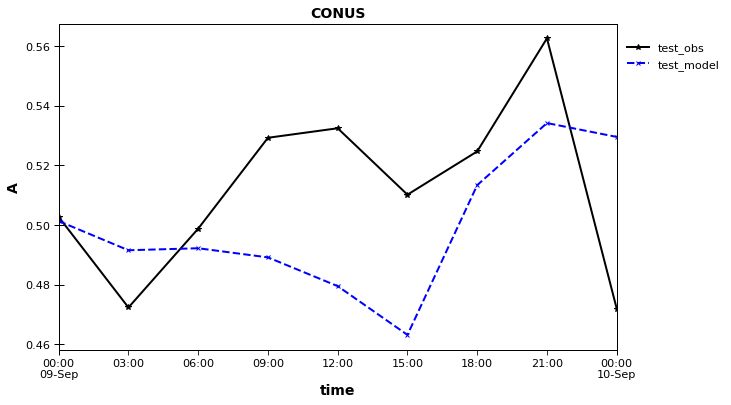

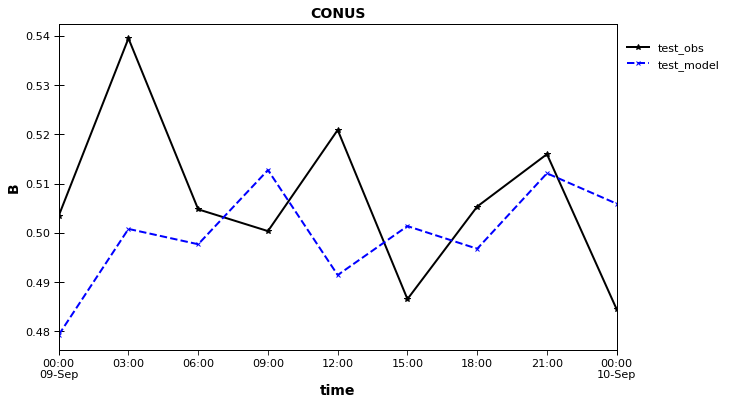

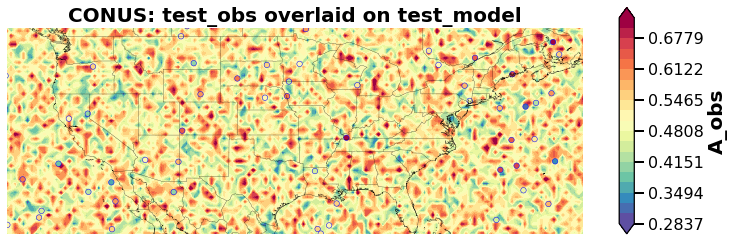

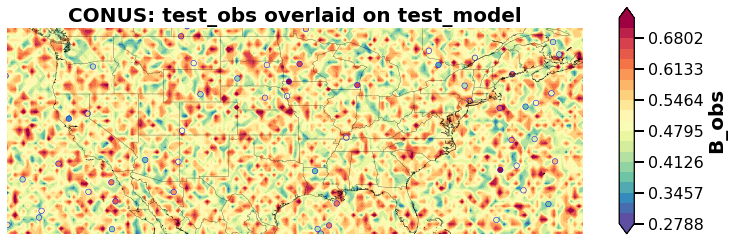

In [16]:
%%time

an.plotting()